<table>
  <tr>
    <td><p style="font-size:45px; color: #55BBD2">Analysis of light microscopy images in Python</p></td>
    <td><img src="../ressources/lmb_logo.svg" alt="LMB Logo" width="500" height="600" align="right"></td>
  </tr>
</table>
<table>
  <tr>
    <td><p style="font-size:15px; color: #55BBD2">Version: September 2025</p></td>
  </tr>
</table>

# Part 3 Colocalization Analysis

<b>Objectives:</b>
- Get to know CellPose and use it to perform cellular segementation (models.Cellpose, model.eval)
- Use Pearson Corrlation Coefficience (PCC) to evaluate colocalization (scipy.stats.pearsonr)
- Simple example of statistical anaysis (scipy.stats.mannwhitneyu, sns.violinplot, sns.stripplot, statannotations.Annotator, plt.savefig)
- Launch CellPose GUI from notebook (!) and retrain custom models using the GUI and use the custom model with Python

<b>Section 1:</b> In this example, we are interested into quantifying the capture of syntaxin-16 cargos vesicles by the mitochondria when the protein TBC1D23 is relocated to the mitochondria. We want to quantify for each cell the level of colocalization between the mitochondria and the cargo to measure the effect of mutant of TBC1D23 on the effectivness of the cargo tethering. Note that not all cells are transfected; syntaxin-16 cargos vesicles will be captured by Glogi in WT cells.

<b>Dataset 1:</b> Zeiss1344.lsm

![title](../ressources/data2.png)

<b>Credit:</b> Alison Gillingham from Sean Munro's group at the MRC-LMB. Reference: Jérôme Cattin-Ortolá et al., Cargo selective vesicle tethering: The structural basis for binding of specific cargo proteins by the Golgi tether component TBC1D23. Sci. adv.10,eadl0608(2024). [https://www.science.org/doi/10.1126/sciadv.adl0608]

<b>Workflow:</b>

<img src="../ressources/workflow/workflow2.png" alt="drawing" width="800"/>

<b>Section 2 (Live Demo):</b> Human-in-the-loop (HITL) in Cellpose allows users to improve segmentation by correcting masks and retraining the model directly in the GUI. It's useful when pretrained models underperform or when a custom model is needed. With just a few manual corrections, users can adapt Cellpose to their data without coding, enabling fast and effective segmentation refinement.

<b>Dataset 2:</b> Human_in_the_loop folder

<img src="../ressources/data2_2.png" alt="drawing" width="400"/>

<b>Credit:</b> Modified from Broad Bioimage Benchmark Collection -- BBBC020. [https://bbbc.broadinstitute.org/BBBC020]

## Load data for colocalization analysis

In [1]:
from pathlib import Path
from bioio import BioImage

data_folder = Path("../data")
image_path = data_folder / "Zeiss1344.lsm"
img = BioImage(image_path).data
print(img.shape)

(1, 4, 1, 1220, 1220)


## Check for GPU Availability
Checks for a CUDA-compatible GPU, which significantly accelerates deep learning model training and inference.

In [2]:
import torch

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

use_gpu = torch.cuda.is_available()

2.8.0
None
False


## Segment the cell using CellPose (Deep Learning approach)

[Cellpose](https://cellpose.readthedocs.io/en/latest/) is a generalist cellular segmentation algorithm, trained on diverse datasets that works on wide range of data types.

Key features: 
- Instance segmentation
- Easy-to-use GUI
- A “zoo” of pre-trained models
- Simple fine-tuning of models via Human-in-the-loop retraining
- Python API

<img src="../ressources/cellpose.png" alt="drawing" width="800"/>


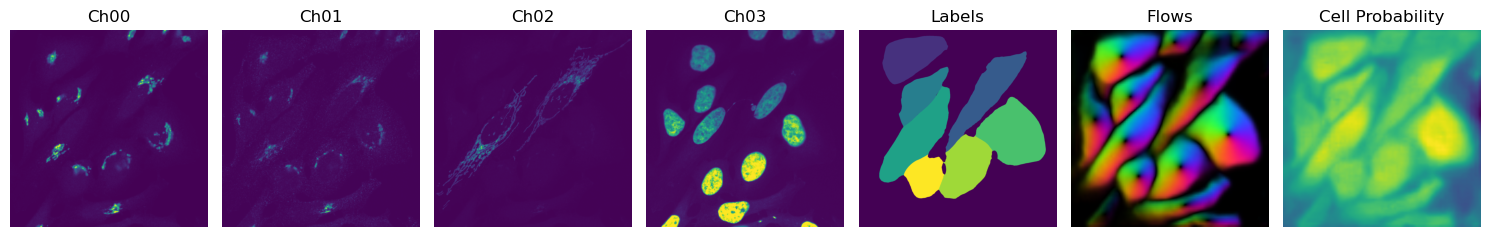

In [3]:
import matplotlib.pyplot as plt
from cellpose import models

# Get the pretrained model
model = models.Cellpose(gpu=use_gpu, model_type="cyto2")

# To segment the cells in the image, we use channels 2 (mitochondria) and 3 (nuclei) for guidance.

mask, flows, styles, diams = model.eval(
    img, channels=[2, 3], diameter=400, cellprob_threshold=1.0
)
"""
Parameters:
-----------
img : np.ndarray
    Input image to segment. For example, a 2D image or an image stack.

channels : list of int
    Specifies which channels to use from the image:
    - channels[0]: main input channel (e.g. cytoplasmic, brightfield, etc.)
    - channels[1]: optional auxiliary channel (e.g. nuclear, membrane marker)
    Example: [2, 3] uses channel 2 and 3 as input.

diameter : float or int
    Estimated object diameter (in pixels). Used to rescale the image internally to match the training conditions of the model
    - A good estimate improves segmentation accuracy.

cellprob_threshold : float
    Threshold applied to the internal "cell probability" map output by the model.
    - Higher values result in stricter segmentation (fewer false positives).
    - Typical range: 0.0 to 1.0

Returns:
--------
mask : np.ndarray
    Segmentation mask with labeled regions (same shape as input image).

flows : list of np.ndarray
    List of flow outputs used internally for mask reconstruction and quality control.
    - flows[0]: cell probability map
    - flows[1]: horizontal/vertical gradient flows
    - flows[2]: divergence map (optional)

styles : np.ndarray
    Feature vector encoding the "style" of the image, used for clustering or diagnostics.

diams : float
    Estimated object diameter based on image content (may differ from input diameter).
"""


# Display the results
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for k in range(4):
    ax[k].imshow(img[:, k, :, :, :].squeeze())
    ax[k].set_axis_off()
    ax[k].set_title("Ch0" + str(k))
ax[4].imshow(mask)
ax[4].set_axis_off()
ax[4].set_title("Labels")
ax[5].imshow(flows[0])
ax[5].set_axis_off()
ax[5].set_title("Flows")
ax[6].imshow(flows[2])
ax[6].set_axis_off()
ax[6].set_title("Cell Probability")
fig.tight_layout()

## Regions properties & Mask overlay in Napari

In [4]:
from skimage import measure
import napari

props = measure.regionprops(mask)

viewer = napari.Viewer()
viewer.add_image(
    img,
    channel_axis=1,
    name=["Golgi", "Cargo", "Mitochondria", "Nuclei"],
    colormap=["green", "magenta", "cyan", "blue"],  # Assign colors to each channel
    blending="additive",  # Better for multichannel visualization
)

# Add segmentation mask as labels layer
viewer.add_labels(
    mask,
    name="Segmentation Mask",
    opacity=0.7,  # Make mask semi-transparent
    blending="translucent",  # Good blending mode for overlays
)
# viewer.show()

<Labels layer 'Segmentation Mask' at 0x35b8063c0>

<div class="alert alert-success">

#### Exercise       

The cell segmentation was obtained after setting the parameters: diameter to 400 pixels and cellprob_threshold = 1.0. <br>
Observe the segmented regions change if you change the diameter or the cellprob_threshold.    
</div>

## Measure the colocalization coefficient 

The Pearson's correlation coefficient (PCC) is widely used to quantify the colocalization of one object $A$ into another object $B$. It can be calculated using the following formula [1]:

$$\text{PCC} = \frac{\sum_i\left( A_i - A_{aver} \right) \cdot \left( B_i - B_{aver} \right)}{\sqrt{\left[ \sum_i \left( A_i - A_{aver} \right)^2 \cdot \sum_i \left( B_i - B_{aver} \right)^2 \right]}}$$

$A$: cargo protein with $A_i$ being the intensity at pixel $i$ and $A_{aver}$ the average value intensity \
$B$: organelles (mitochondria or Golgi) with $B_i$ being the intensity at pixel $i$ and $B_{aver}$ the average value intensity

PCC values range from –1 to 1, where 1 indicates perfect colocalization and –1 indicates complete exclusion. We will calculate the correlation between the cargo protein and either mitochondria or Golgi to quantify cargo relocation. PCC values will be compared between cells with high (transfected) and low (not transfected) mitochondrial presence. <br>

We will apply the following notations:
- PCC1: PCC between the cargo protein and Golgi 
- PCC2: PCC between the cargo protein and mitochondria

Reference [1]: Manders, E.M., Verbeek, F.J. and Aten, J.A., 1993. Measurement of co‐localization of objects in dual‐colour confocal images. Journal of microscopy, 169(3), pp.375-382.

In [5]:
import scipy.stats
import pandas as pd


colcoeff = []  # List to store Pearson correlation results and associated measurements for each object
intensity_threshold =  1e6  # Threshold to determine whether a cell is considered "transfected"


# Loop through each object in the regionprops list
for p in props:
    # Extract intensity values for each channel at the coordinates of the current object (labelled region)
    ch00 = img[:, 0, :, :].squeeze()[p.coords[:, 0], p.coords[:, 1]]  # Channel 0: Golgi marker
    ch01 = img[:, 1, :, :].squeeze()[p.coords[:, 0], p.coords[:, 1]]  # Channel 1: Cargo protein
    ch02 = img[:, 2, :, :].squeeze()[p.coords[:, 0], p.coords[:, 1]]  # Channel 2: Mitochondria

    # Compute the total intensity of mitochondria in this object
    sum_mitochondria = ch02.sum()
    # Determine transfection condition based on mitochondria intensity
    if sum_mitochondria >= intensity_threshold:
        c = "Transfected"
    else:
        c = "Not transfected"

    # Compute Pearson correlation coefficient between:
    # - Golgi and Cargo protein
    [r1, pv] = scipy.stats.pearsonr(ch00, ch01)
    # - Cargo protein and Mitochondria
    [r2, pv] = scipy.stats.pearsonr(ch01, ch02)
    # - pv is the two-tailed (default hypothesis) p-value testing non-correlation

    # Append results as a dictionary to the list
    colcoeff.append(
        {
            "label": p.label,  # Object label
            "PCC1": r1,  # Pearson correlation: Golgi vs Cargo
            "PCC2": r2,  # Pearson correlation: Cargo vs Mitochondria
            "Area": p.area,  # Area of the object
            "Integrated intensity": sum_mitochondria,  # Total mitochondria intensity
            "Condition": c,  # Transfection status
        }
    )

# Convert the list of dictionaries to a pandas DataFrame for easier downstream analysis
colcoeff = pd.DataFrame.from_records(colcoeff)
# Display the DataFrame
colcoeff

,label,PCC1,PCC2,Area,Integrated intensity,Condition
0,1,0.849356,0.389726,77252.0,348386,Not transfected
1,2,0.712557,0.653804,93217.0,1270290,Transfected
2,3,0.795262,0.344398,52433.0,248402,Not transfected
3,4,0.699592,0.684834,108757.0,1580412,Transfected
4,5,0.772451,0.475691,117915.0,538302,Not transfected
5,6,0.646166,0.462910,85770.0,401221,Not transfected
6,7,0.756166,0.314768,45857.0,226718,Not transfected


## Statistical analysis
We would like to analyze the capture of the cargo to the mitochondria due to the protein TBC1D23 relocalization: to compare the PCC between the cargo and mitochondria signal (PCC2) in two groups of cells: transfected (with high mitochondrial content) and non-transfected (with low mitochondrial content). 

### P-value
The p-value is obtained from a statistical test (Mann–Whitney U test) comparing PCC2 values between transfected and non-transfected cells. It reflects the probability of observing such a difference by chance if there were no actual relationship between mitochondrial content and cargo–mitochondria colocalization. A smaller p-value indicates stronger evidence that the two groups differ in terms of PCC2.

In [9]:
# Filter the DataFrame to separate objects based on their transfection condition
grp1 = colcoeff[colcoeff["Condition"] == "Transfected"]  # Subset of transfected objects
grp2 = colcoeff[
    colcoeff["Condition"] == "Not transfected"
]  # Subset of non-transfected objects

# Perform a Mann-Whitney U test (non-parametric test) to compare the PCC2 values
# between transfected and non-transfected groups
pvalue = scipy.stats.mannwhitneyu(grp1["PCC2"], grp2["PCC2"])

# Print the resulting p-value (and test statistic) to evaluate if there's a significant difference
print(pvalue)

MannwhitneyuResult(statistic=np.float64(10.0), pvalue=np.float64(0.09523809523809523))


## Display of the result
Display the PCC values, annotate the p-value and save the result into pdf file

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Not transfected vs. Transfected: Custom statistical test, P_val:9.524e-02


/Users/qwu/micromamba/envs/imaging-python-course/lib/python3.13/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


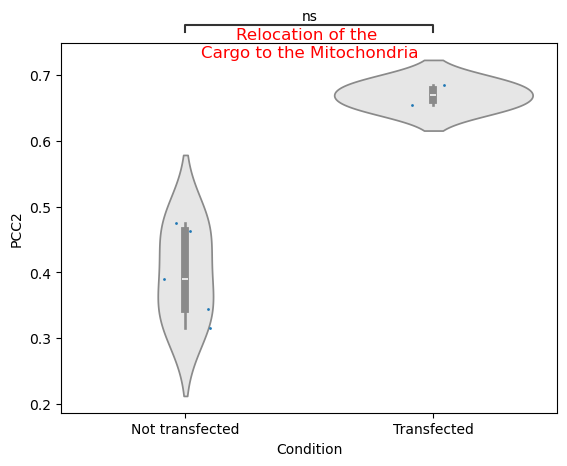

In [7]:
# Import seaborn for plotting and statannotations for statistical annotation on plots
import seaborn as sns
from statannotations.Annotator import Annotator

# Define the two experimental conditions in desired plotting order
conditions_list = ["Not transfected", "Transfected"]

# Create a dictionary of plotting parameters for reuse (cleaner code)
plotting_parameters = {
    "data": colcoeff,  # DataFrame containing PCC values and metadata
    "x": "Condition",  # X-axis will show the condition (transfection status)
    "y": "PCC2",  # Y-axis will show the PCC between mitochondria and Cargo
    "order": conditions_list,  # Force consistent order of conditions
}

# Create a violin plot showing the distribution of PCC2 in each condition
ax = sns.violinplot(**plotting_parameters, color="0.9")
# Overlay individual data points using a stripplot (adds visibility to distribution)
sns.stripplot(**plotting_parameters, jitter=True, size=2)

# Set up the Annotator to add statistical test result on the plot
annotator = Annotator(ax, tuple([conditions_list]), **plotting_parameters)
# Provide the p-value from the Mann-Whitney U test
annotator.set_pvalues([pvalue.pvalue])
# Configure annotation display: show p-value outside the plot area
annotator.configure(loc="outside")
# Draw the annotation on the plot
annotator.annotate()

# Set the title of the plot with red text and slightly adjusted vertical placement
ax.set_title(
    "Relocation of the \nCargo to the Mitochondria",
    y=1.0,
    pad=-10,
    c="red",
    horizontalalignment="center",
)

# Save the figure to PDF with tight layout to avoid cutting off elements
plt.savefig("PCC_Cargo_to_Mitochondria.pdf", format="pdf", bbox_inches="tight")


<div class="alert alert-success">

#### Exercise       

Display the result of the statistical analysis which corresponds to the relocation of the cargo to the Golgi. <br>
Make sure the title of the figure and the name under which the figure will be saved are updated.
   
</div>

# Human-in-the-loop Segmentation with Cellpose (Quick Demo)

In [ ]:
# Launch Cellpose GUI (currently command for Windows)
! cellpose

2025-09-11 18:07:41,012 [INFO] WRITING LOG OUTPUT TO C:\Users\User\.cellpose\run.log
2025-09-11 18:07:41,012 [INFO] 
cellpose version: 	3.1.1.2 
platform:       	win32 
python version: 	3.10.18 
torch version:  	2.8.0+cu129
2025-09-11 18:07:41,590 [INFO] ** TORCH CUDA version installed and working. **


# Human‑in‑the‑Loop Segmentation with Cellpose (Quick Demo)

### 1 Load & Configure
- Open a one representative image.
- Pick a pretrained model (e.g., **cyto2**, **nuclei**, or **omni**).
- Set **Channels** (main + optional aux) to match your data.
- Set **Diameter** (or use **Auto**).

### 2 First Pass Segmentation
- Click **Run** to generate masks.
- Inspect overlays (toggle labels on/off; use mouse wheel to zoom in on tricky regions).

### 3 Human Corrections (the “loop”)
- **Add missing cells** rigth click and draw.
- **Remove false positives** with click and delete.
- This creates training-ready mask files matching the image names in the same folder.

### 4 Train a Custom Model
- Go to the **Train** tab:
  - Select your corrected images and masks folder.
  - Choose a pre-trained model (e.g., **cyto2**) and a short training run (default value usually works fine).
  - Start training 
  - Cellpose will save a model under `models/`.

### 6 Apply the New Model
- Switch to your newly trained model in the GUI.
- Batch‑process remaining images with it.
- Spot‑check results; repeat corrections and training if needed.

###  Tips
- Start with **3–5 diverse images** for your first correction cycle.
- Keep early training **short** for fast iteration.
- Revisit channel/diameter settings if segmentation errors persist.


<div class="alert alert-success">

#### Exercise

Use your custom trained Cellpose model to segment new images with Python. <br>
Hint: <br>
Give the path to your model with model_path = '../models/my_model'<br>
Load the model with model_retrain = models.CellposeModel()<br>
Run model_retrain.eval() on your test image<br>

</div>